In [1]:
import pylhe
import ROOT
import math
import os
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.20/04


In [2]:
##### setting file path #####

sig_rootpath = "/data/Chen-Wang/zaSIG1/Events/run_01/tag_1_delphes_events.root"
sig_file = uproot.open(sig_rootpath)

bg_aa_rootpath = "/data/Chen-Wang/llaaBGlarge/Events/run_01/tag_1_delphes_events.root"
bg_aa_file = uproot.open(bg_aa_rootpath)

bg_jet_rootpath = "/data/Chen-Wang/lljBGlarge/Events/run_01/tag_1_delphes_events.root"
bg_jet_file = uproot.open(bg_jet_rootpath)

In [3]:
##### set signal event content #####

sig_events = [sig_file["Delphes;1"]["Electron"].array(),
              sig_file["Delphes;1"]["Electron.PT"].array(),
              sig_file["Delphes;1"]["Electron.Phi"].array(),
              sig_file["Delphes;1"]["Electron.Eta"].array(),
              sig_file["Delphes;1"]["Muon"].array(),
              sig_file["Delphes;1"]["Muon.PT"].array(),
              sig_file["Delphes;1"]["Muon.Phi"].array(),
              sig_file["Delphes;1"]["Muon.Eta"].array(),
              sig_file["Delphes;1"]["Jet"].array(),
              sig_file["Delphes;1"]["Jet.EhadOverEem"].array(),
              sig_file["Delphes;1"]["Jet.Mass"].array(),
              sig_file["Delphes;1"]["Event.Number"].array(),
              sig_file["Delphes;1"]["Jet.Tau[5]"].array()
             ]

sig_events = np.expand_dims(sig_events, axis=-1)    ### reshape data
sig_events = sig_events.transpose((1,0,2))
sig_events = np.squeeze(sig_events,axis=(2,))

##### set llaa background event content #####

bg_aa_events = [bg_aa_file["Delphes;1"]["Electron"].array(),
             bg_aa_file["Delphes;1"]["Electron.PT"].array(),
             bg_aa_file["Delphes;1"]["Electron.Phi"].array(),
             bg_aa_file["Delphes;1"]["Electron.Eta"].array(),
             bg_aa_file["Delphes;1"]["Muon"].array(),
             bg_aa_file["Delphes;1"]["Muon.PT"].array(),
             bg_aa_file["Delphes;1"]["Muon.Phi"].array(),
             bg_aa_file["Delphes;1"]["Muon.Eta"].array(),
             bg_aa_file["Delphes;1"]["Jet"].array(),
             bg_aa_file["Delphes;1"]["Jet.EhadOverEem"].array(),
             bg_aa_file["Delphes;1"]["Jet.Mass"].array(),
             bg_aa_file["Delphes;1"]["Event.Number"].array(),
             bg_aa_file["Delphes;1"]["Jet.Tau[5]"].array()
             ]

bg_aa_events = np.expand_dims(bg_aa_events, axis=-1)    ### reshape data
bg_aa_events = bg_aa_events.transpose((1,0,2))
bg_aa_events = np.squeeze(bg_aa_events,axis=(2,))

##### set llj background event content #####

bg_jet_events = [bg_jet_file["Delphes;1"]["Electron"].array(),
             bg_jet_file["Delphes;1"]["Electron.PT"].array(),
             bg_jet_file["Delphes;1"]["Electron.Phi"].array(),
             bg_jet_file["Delphes;1"]["Electron.Eta"].array(),
             bg_jet_file["Delphes;1"]["Muon"].array(),
             bg_jet_file["Delphes;1"]["Muon.PT"].array(),
             bg_jet_file["Delphes;1"]["Muon.Phi"].array(),
             bg_jet_file["Delphes;1"]["Muon.Eta"].array(),
             bg_jet_file["Delphes;1"]["Jet"].array(),
             bg_jet_file["Delphes;1"]["Jet.EhadOverEem"].array(),
             bg_jet_file["Delphes;1"]["Jet.Mass"].array(),
             bg_jet_file["Delphes;1"]["Event.Number"].array(),
             bg_jet_file["Delphes;1"]["Jet.Tau[5]"].array()
             ]

bg_jet_events = np.expand_dims(bg_jet_events, axis=-1)    ### reshape data
bg_jet_events = bg_jet_events.transpose((1,0,2))
bg_jet_events = np.squeeze(bg_jet_events,axis=(2,))

##### event features #####

features = ["Electron", "Electron.PT", "Electron.Phi", "Electron.Eta", "Muon", "Muon.PT", "Muon.Phi", "Muon.Eta", "Jet", "Jet.EhadOverEem", "Jet.Mass", "Event.Number", "Jet.Tau[5]"]
electron_mass = 0.000511
muon_mass = 0.10566

In [4]:
################################
##### Some useful function #####
################################

##### select if =2 photon #####
#
#def photon_selection(events):
#    where2photon = np.where(events[:,8]==2)    ### 8:number of photon
#    return events[where2photon]

##### select at least 1 jet #####

def jet_selection(events):
    where1 = np.where(events[:,8]>0)    ### 8:number of jets
    return events[where1]

##### select minimum theta <0.02

def theta_selection(events):
    where1 = []
    for i in range(len(events)):
        min_theta = np.min(events[i][9])    ### 9:jet theta (Jet.EhadOverEem)
        if min_theta<0.02:
            where1.append(i)
    return events[where1]

##### select if =2 lepton #####

def lepton_selection(events):
    where_electron = np.where(events[:,0]==2)    ### 0:number of electron
    where_muon = np.where(events[:,4]==2)    ### 4:number of muon
    return events[where_electron], events[where_muon]

##### calculate m_ll #####

def m_ll(events, m_ll):
    where1 = []
    where_select = []
    for i in range(len(events)):
        p = [0,0,0,0]    ### four momentum
        if events[i][0]==2:    ### electron case
            for j in range(2):
                pt = events[i][1][j]    ### 1:electron transverse momentum
                phi = events[i][2][j]    ### 2:electron polar angle
                eta = events[i][3][j]    ### 3:electron pseudorapidity
                p[1] = p[1] + pt*np.cos(phi)    ### px
                p[2] = p[2] + pt*np.sin(phi)    ### py
                p[3] = p[3] + pt*np.sinh(eta)    ### pz
                p[0] = p[0] + np.sqrt( electron_mass**2 + (pt*np.cos(phi))**2 + (pt*np.sin(phi))**2 + (pt*np.sinh(eta))**2 )    ### energy
        elif events[i][4]==2:    ### muon case
            for j in range(2):
                pt = events[i][5][j]    ### 5:muon transverse momentum
                phi = events[i][6][j]    ### 6:muon polar angle
                eta = events[i][7][j]    ### 7:muon pseudorapidity
                p[1] = p[1] + pt*np.cos(phi)    ### px
                p[2] = p[2] + pt*np.sin(phi)    ### py
                p[3] = p[3] + pt*np.sinh(eta)    ### pz
                p[0] = p[0] + np.sqrt( muon_mass**2 + (pt*np.cos(phi))**2 + (pt*np.sin(phi))**2 + (pt*np.sinh(eta))**2 )    ### energy
        mll = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 - p[3]**2)
        if 30<=mll<=250:
            m_ll.append(mll)
            where1.append(i)
        if 80<=mll<=100:
            where_select.append(i)
    return events[where1], events[where_select]

##### calculate m_aa and pT_aa #####
#
#def m_aa(events, m_aa, pT_aa):
#    for i in range(len(events)):
#        p = [0,0,0,0]    ### four momentum
#        for j in range(events[i][8]):
#            pt = events[i][9][j]    ### 9:photon transverse momentum
#            phi = events[i][10][j]    ### 10:photon polar angle
#            eta = events[i][11][j]    ### 11:photon pseudorapidity
#            p[1] = p[1] + pt*np.cos(phi)    ### px
#            p[2] = p[2] + pt*np.sin(phi)    ### py
#            p[3] = p[3] + pt*np.sinh(eta)    ### pz
#            p[0] = p[0] + np.sqrt( (pt*np.cos(phi))**2 + (pt*np.sin(phi))**2 + (pt*np.sinh(eta))**2 )    ### energy with photon mass=0
#        maa = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 - p[3]**2)
#        m_aa.append(maa)
#        pTaa = np.sqrt(p[1]**2 + p[2]**2)
#        pT_aa.append(pTaa)
        
##### collect jet mass #####

def m_jet(events, m_jet):
    where1 =[]
    for i in range(len(events)):
        where_min_theta = np.where(events[i][9] == np.min(events[i][9]))[0]    ### 9:jet theta
        for j in range(len(where_min_theta)):
            jet_mass = events[i][10][where_min_theta[j]]    ### 10:jet mass
            if 0.1<jet_mass<7.5:
                where1.append(i)
                m_jet.append(jet_mass)
    where1 = np.unique(where1)
    return events[where1]

##### select jet mass #####

def select_m_jet(events):
    where1 = []
    for i in range(len(events)):
        where_min_theta = np.where(events[i][9] == np.min(events[i][9]))[0]    ### 9:jet theta
        for j in range(len(where_min_theta)):
            jet_mass = events[i][10][where_min_theta[j]]    ### 10:jet mass
            if 0.5<jet_mass<2:
                where1.append(i)
    where1 = np.unique(where1)
    if len(where1)>0:
        return events[where1]
    elif len(where1)==0:
        return []

##### copute Tau2/Tau1 (N-subjettiness) #####

def Tau2overTau1(events, Tau2overTau1):
    for i in range(len(events)):
        where_min_theta = np.where(events[i][9] == np.min(events[i][9]))[0]    ### 9:jet theta
        for j in range(len(where_min_theta)):
            Tau1 = events[i][12][where_min_theta[j]][0]
            Tau2 = events[i][12][where_min_theta[j]][1]
            if Tau1!=0:
                Tau2overTau1.append(Tau2/Tau1)
                
##### select Tau2/Tau1 (N-subjettiness) #####

def Nsubjettiness_selection(events):
    where1 = []
    for i in range(len(events)):
        where_min_theta = np.where(events[i][9] == np.min(events[i][9]))[0]    ### 9:jet theta
        for j in range(len(where_min_theta)):
            Tau1 = events[i][12][where_min_theta[j]][0]
            Tau2 = events[i][12][where_min_theta[j]][1]
            if Tau1!=0:
                if Tau2/Tau1<0.05:
                    where1.append(i)
    return events[where1]

In [5]:
##### signal events selection #####

print("total signal events:", len(sig_events))
sig_events = jet_selection(sig_events)
print("events after 1 jet selection:", len(sig_events))
sig_events = theta_selection(sig_events)
print("events after minimum theta selection:", len(sig_events))
sig_electron_events, sig_muon_events = lepton_selection(sig_events)
print("2 electron events:", len(sig_electron_events))
print("2 muon events:", len(sig_muon_events))

##### 2 photon background events selection #####

print("\ntotal 2 photon background events:", len(bg_aa_events))
bg_aa_events = jet_selection(bg_aa_events)
print("events after 1 jet selection:", len(bg_aa_events))
bg_aa_events = theta_selection(bg_aa_events)
print("events after minimum theta selection:", len(bg_aa_events))
bg_aa_electron_events, bg_aa_muon_events = lepton_selection(bg_aa_events)
print("2 electron events:", len(bg_aa_electron_events))
print("2 muon events:", len(bg_aa_muon_events))

##### jet background events selection #####

print("\ntotal 1 jet background events:", len(bg_jet_events))
bg_jet_events = jet_selection(bg_jet_events)
print("events after 1 jet selection:", len(bg_jet_events))
bg_jet_events = theta_selection(bg_jet_events)
print("events after minimum theta selection:", len(bg_jet_events))
bg_jet_electron_events, bg_jet_muon_events = lepton_selection(bg_jet_events)
print("2 electron events:", len(bg_jet_electron_events))
print("2 muon events:", len(bg_jet_muon_events))

total signal events: 10000
events after 1 jet selection: 8578
events after minimum theta selection: 6481
2 electron events: 772
2 muon events: 1282

total 2 photon background events: 100000
events after 1 jet selection: 58285
events after minimum theta selection: 27417
2 electron events: 1430
2 muon events: 2501

total 1 jet background events: 100000
events after 1 jet selection: 84673
events after minimum theta selection: 15766
2 electron events: 140
2 muon events: 250


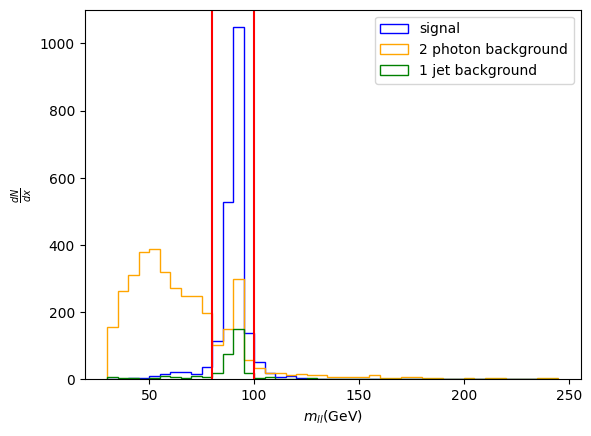

signal events: 2052
2 photon background events: 3614
1 jet background events: 340

selected signal events: 1829
selected 2 photon background events: 609
selected 1 jet background events: 261


In [6]:
##### plot m_ll #####

sig_m_ll = []
bg_aa_m_ll = []
bg_jet_m_ll = []

sig_electron_events, sig_electron_select = m_ll(sig_electron_events, sig_m_ll)
sig_muon_events, sig_muon_select = m_ll(sig_muon_events, sig_m_ll)

bg_aa_electron_events, bg_aa_electron_select = m_ll(bg_aa_electron_events, bg_aa_m_ll)
bg_aa_muon_events, bg_aa_muon_select = m_ll(bg_aa_muon_events, bg_aa_m_ll)

bg_jet_electron_events, bg_jet_electron_select = m_ll(bg_jet_electron_events, bg_jet_m_ll)
bg_jet_muon_events, bg_jet_muon_select = m_ll(bg_jet_muon_events, bg_jet_m_ll)

bins = np.arange(30,250,5)
plt.hist(sig_m_ll, bins=bins, label="signal", histtype='step', color='blue')
plt.hist(bg_aa_m_ll, bins=bins, label="2 photon background", histtype='step', color='orange')
plt.hist(bg_jet_m_ll, bins=bins, label="1 jet background", histtype='step', color='green')
plt.axvline(80, color='r')
plt.axvline(100, color='r')
plt.xlabel(r"$m_{ll}$(GeV)")
plt.ylabel(r"$\frac{dN}{dx}$")
plt.legend(loc='best')
plt.show()

print("signal events:", len(sig_m_ll))
print("2 photon background events:", len(bg_aa_m_ll))
print("1 jet background events:", len(bg_jet_m_ll))

print("\nselected signal events:", len(sig_electron_select)+len(sig_muon_select))
print("selected 2 photon background events:", len(bg_aa_electron_select)+len(bg_aa_muon_select))
print("selected 1 jet background events:", len(bg_jet_electron_select)+len(bg_jet_muon_select))

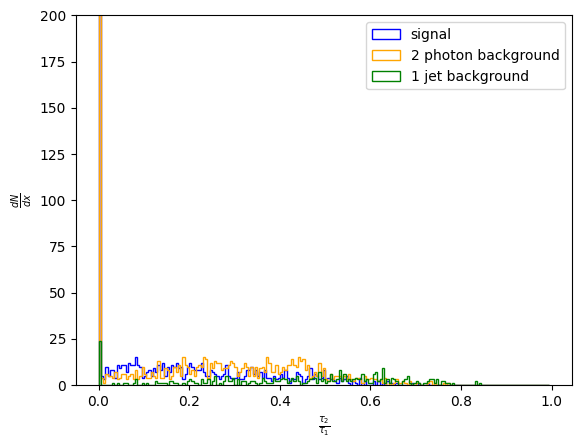

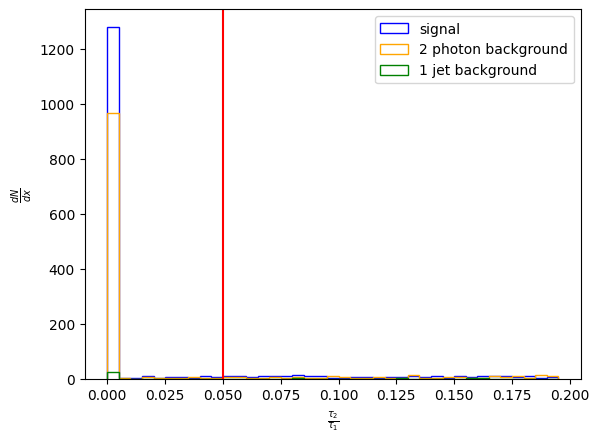

In [7]:
##### plot Tau2/Tau1 (N-subjettiness) #####

sig_Tau2overTau1 = []
bg_aa_Tau2overTau1 = []
bg_jet_Tau2overTau1 = []

Tau2overTau1(sig_electron_events, sig_Tau2overTau1)
Tau2overTau1(sig_muon_events, sig_Tau2overTau1)

Tau2overTau1(bg_aa_electron_events, bg_aa_Tau2overTau1)
Tau2overTau1(bg_aa_muon_events, bg_aa_Tau2overTau1)

Tau2overTau1(bg_jet_electron_events, bg_jet_Tau2overTau1)
Tau2overTau1(bg_jet_muon_events, bg_jet_Tau2overTau1)

bins = np.arange(0,1,0.005)
plt.hist(sig_Tau2overTau1, bins=bins, label="signal", histtype='step', color='blue')
plt.hist(bg_aa_Tau2overTau1, bins=bins, label="2 photon background", histtype='step', color='orange')
plt.hist(bg_jet_Tau2overTau1, bins=bins, label="1 jet background", histtype='step', color='green')
plt.ylim((0,200))
plt.xlabel(r"$\frac{\tau_2}{\tau_1}$")
plt.ylabel(r"$\frac{dN}{dx}$")
plt.legend(loc='best')
plt.show()

bins = np.arange(0,0.2,0.005)
plt.hist(sig_Tau2overTau1, bins=bins, label="signal", histtype='step', color='blue')
plt.hist(bg_aa_Tau2overTau1, bins=bins, label="2 photon background", histtype='step', color='orange')
plt.hist(bg_jet_Tau2overTau1, bins=bins, label="1 jet background", histtype='step', color='green')
plt.axvline(0.05, color='r')
plt.xlabel(r"$\frac{\tau_2}{\tau_1}$")
plt.ylabel(r"$\frac{dN}{dx}$")
plt.legend(loc='best')
plt.show()

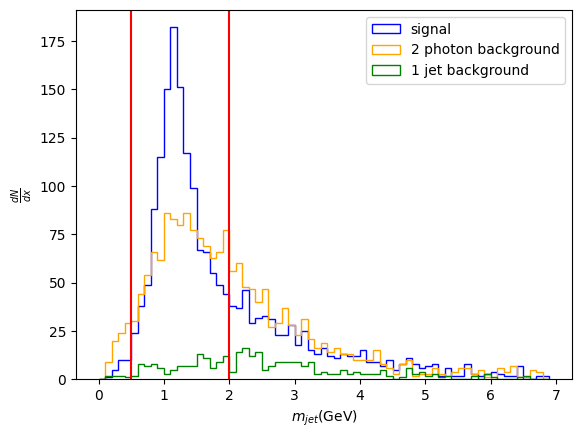

signal events: 1957
2 photon background events: 1852
1 jet background events: 315

average signal jet mass: 1.9351151


In [8]:
##### plot m_jet #####

sig_m_jet = []
bg_aa_m_jet = []
bg_jet_m_jet = []

sig_electron_events = m_jet(sig_electron_events, sig_m_jet)
sig_muon_events = m_jet(sig_muon_events, sig_m_jet)

bg_aa_electron_events = m_jet(bg_aa_electron_events, bg_aa_m_jet)
bg_aa_muon_events = m_jet(bg_aa_muon_events, bg_aa_m_jet)

bg_jet_electron_events = m_jet(bg_jet_electron_events, bg_jet_m_jet)
bg_jet_muon_events = m_jet(bg_jet_muon_events, bg_jet_m_jet)

bins = np.arange(0, 7, 0.1)
sig = plt.hist(sig_m_jet, bins=bins, label="signal", histtype='step', color='blue')
plt.hist(bg_aa_m_jet, bins=bins, label="2 photon background", histtype='step', color='orange')
plt.hist(bg_jet_m_jet, bins=bins, label="1 jet background", histtype='step', color='green')
plt.xlabel(r"$m_{jet}$(GeV)")
plt.ylabel(r"$\frac{dN}{dx}$")
#plt.text(170,60,"58 signal events")
#plt.text(170,65,"1670 background events")
plt.axvline(0.5, color='r')
plt.axvline(2, color='r')
plt.legend(loc='best')
plt.show()

print("signal events:", len(sig_m_jet))
print("2 photon background events:", len(bg_aa_m_jet))
print("1 jet background events:", len(bg_jet_m_jet))
print("\naverage signal jet mass:", np.average(sig_m_jet))

In [9]:
##### Nsubjettiness selection #####

sig_electron_select = Nsubjettiness_selection(sig_electron_select)
sig_muon_select = Nsubjettiness_selection(sig_muon_select)

bg_aa_electron_select = Nsubjettiness_selection(bg_aa_electron_select)
bg_aa_muon_select = Nsubjettiness_selection(bg_aa_muon_select)

bg_jet_electron_select = Nsubjettiness_selection(bg_jet_electron_select)
bg_jet_muon_select = Nsubjettiness_selection(bg_jet_muon_select)

print("signal events after Nsubjettiness selection:", len(sig_electron_select)+len(sig_muon_select))
print("2 photon background events after Nsubjettiness selection:", len(bg_aa_electron_select)+len(bg_aa_muon_select))
print("1 jet background events after Nsubjettiness selection:", len(bg_jet_electron_select)+len(bg_jet_muon_select))

signal events after Nsubjettiness selection: 1193
2 photon background events after Nsubjettiness selection: 153
1 jet background events after Nsubjettiness selection: 16


In [10]:
##### select m_jet #####

sig_electron_select = select_m_jet(sig_electron_select)
sig_muon_select = select_m_jet(sig_muon_select)

bg_aa_electron_select = select_m_jet(bg_aa_electron_select)
bg_aa_muon_select = select_m_jet(bg_aa_muon_select)

bg_jet_electron_select = select_m_jet(bg_jet_electron_select)
bg_jet_muon_select = select_m_jet(bg_jet_muon_select)

print("signal events after m_jet selection:", len(sig_electron_select)+len(sig_muon_select))
print("2 photon background events after m_jet selection:", len(bg_aa_electron_select)+len(bg_aa_muon_select))
print("1 jet background events after m_jet selection:", len(bg_jet_electron_select)+len(bg_jet_muon_select))

signal events after m_jet selection: 978
2 photon background events after m_jet selection: 99
1 jet background events after m_jet selection: 8


In [11]:
##### event information #####

event_num = 5
print("In the", event_num, "th of events:\n")
for i in range(len(features)):
    print(features[i], ":", sig_electron_select[event_num][i])

In the 5 th of events:

Electron : 2
Electron.PT : [44.315617 34.420074]
Electron.Phi : [1.1634293 3.057601 ]
Electron.Eta : [0.9369504 2.4638574]
Muon : 0
Muon.PT : []
Muon.Phi : []
Muon.Eta : []
Jet : 1
Jet.EhadOverEem : [0.00808026]
Jet.Mass : [1.736297]
Event.Number : [72]
Jet.Tau[5] : [[0.00992541 0.         0.         0.         0.        ]]


In [12]:
##### calculate significance and parameter limit in Luminosity = 300(fb^-1) #####

N_sim_sig = 10000
N_sim_bg = 100000
Nselected_sig = 921
Nselected_jet_bg = 8
Nselected_aa_bg = 99
Xsection_sig = 1573.80488    ### unit:fb
Xsection_jet_bg = 549739.9    ### unit:fb
Xsection_aa_bg = 99.09201    ### unit:fb
Luminosity = 300    ### unit:fb^-1
sim_f_a = 1000    ### unit:GeV
C_Wtil = 2
C_Btil = 1
sin_W_square = 0.22290    ### sine square of Weinberg angle
cos_W_square = 1-sin_W_square    ### cosine square of Weinberg angle

print("In Luminosity = 300(fb^-1)")

s = Xsection_sig * (Nselected_sig/N_sim_sig) * Luminosity
jet_b = Xsection_jet_bg * (Nselected_jet_bg/N_sim_bg) * Luminosity
aa_b = Xsection_aa_bg * (Nselected_aa_bg/N_sim_bg) * Luminosity
b = jet_b + aa_b

significance = np.sqrt(2*((s+b)*np.log(1+s/b)-s))
print("significance:", significance)

expected_Xsection = 8.347809
exp_s = expected_Xsection * (Nselected_sig/N_sim_sig) * Luminosity
exp_significance = np.sqrt(2*((exp_s+b)*np.log(1+exp_s/b)-exp_s))
print("\nexpected significance:", exp_significance)
print("when significance=2, signal Xsection:", expected_Xsection, "(fb)")

f_a_limit = sim_f_a*np.sqrt(Xsection_sig/expected_Xsection)
g_azz_limit = 4*(C_Btil*cos_W_square+C_Wtil*sin_W_square)/f_a_limit
g_azgamma_limit = 8*np.sqrt(sin_W_square)*np.sqrt(cos_W_square)*(C_Wtil-C_Btil)/f_a_limit
print("\nupper limit of f_a:", f_a_limit, "(GeV)")
print("lower limit of g_azz:", g_azz_limit, "(GeV^-1)")
print("lower limit of g_azy:", g_azgamma_limit, "(GeV^-1)")

In Luminosity = 300(fb^-1)
significance: 279.5638530145943

expected significance: 2.000000133982307
when significance=2, signal Xsection: 8.347809 (fb)

upper limit of f_a: 13730.589771704113 (GeV)
lower limit of g_azz: 0.0003562556365991335 (GeV^-1)
lower limit of g_azy: 0.00024249025140033248 (GeV^-1)


In [13]:
##### calculate significance and parameter limit in Luminosity = 3000(fb^-1) #####

N_sim_sig = 10000
N_sim_bg = 100000
Nselected_sig = 921
Nselected_jet_bg = 8
Nselected_aa_bg = 99
Xsection_sig = 1573.80488    ### unit:fb
Xsection_jet_bg = 549739.9    ### unit:fb
Xsection_aa_bg = 99.09201    ### unit:fb
Luminosity = 3000    ### unit:fb^-1
sim_f_a = 1000    ### unit:GeV
C_Wtil = 2
C_Btil = 1
sin_W_square = 0.22290    ### sine square of Weinberg angle
cos_W_square = 1-sin_W_square    ### cosine square of Weinberg angle

print("In Luminosity = 3000(fb^-1)")

s = Xsection_sig * (Nselected_sig/N_sim_sig) * Luminosity
jet_b = Xsection_jet_bg * (Nselected_jet_bg/N_sim_bg) * Luminosity
aa_b = Xsection_aa_bg * (Nselected_aa_bg/N_sim_bg) * Luminosity
b = jet_b + aa_b

significance = np.sqrt(2*((s+b)*np.log(1+s/b)-s))
print("significance:", significance)

expected_Xsection = 2.634602
exp_s = expected_Xsection * (Nselected_sig/N_sim_sig) * Luminosity
exp_significance = np.sqrt(2*((exp_s+b)*np.log(1+exp_s/b)-exp_s))
print("\nexpected significance:", exp_significance)
print("when significance=2, signal Xsection:", expected_Xsection, "(fb)")

f_a_limit = sim_f_a*np.sqrt(Xsection_sig/expected_Xsection)
g_azz_limit = 4*(C_Btil*cos_W_square+C_Wtil*sin_W_square)/f_a_limit
g_azgamma_limit = 8*np.sqrt(sin_W_square)*np.sqrt(cos_W_square)*(C_Wtil-C_Btil)/f_a_limit
print("\nupper limit of f_a:", f_a_limit, "(GeV)")
print("lower limit of g_azz:", g_azz_limit, "(GeV^-1)")
print("lower limit of g_azy:", g_azgamma_limit, "(GeV^-1)")

In Luminosity = 3000(fb^-1)
significance: 884.0585269786479

expected significance: 2.0000003826916872
when significance=2, signal Xsection: 2.634602 (fb)

upper limit of f_a: 24440.941707505073 (GeV)
lower limit of g_azz: 0.00020013958784975697 (GeV^-1)
lower limit of g_azy: 0.00013622773645390943 (GeV^-1)
